<a href="https://colab.research.google.com/github/CaptaiN785/DL-Notebooks/blob/main/Cifar10/cifar_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf

In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.cifar10.load_data()

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

(32, 32, 3)


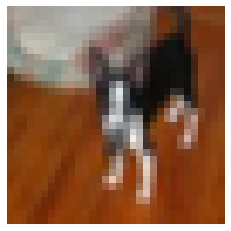

In [31]:
## Cheking the upsampling of images
index = 1244
img = X_train[index]
print(img.shape)
plt.imshow(img)
plt.axis("off")
plt.show()

(224, 224, 3)


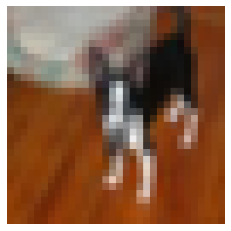

In [32]:
## Now upscaling the image

resize = tf.keras.layers.UpSampling2D(size=(7, 7))
img = resize(np.expand_dims(X_train[index], 0))
print(img[0].shape)
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [71]:
def feature_extractor(input):
    feature_extracted = tf.keras.applications.resnet.ResNet50(
        input_shape=(224, 224, 3),
        include_top = False,
        weights='imagenet'
    )(input)
    return feature_extracted

In [72]:
def classifier(input):
    x = tf.keras.layers.GlobalAveragePooling2D()(input)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(10, activation = 'softmax', name ='classification')(x)
    return x

In [73]:
def final_model(input):
    resize = tf.keras.layers.UpSampling2D(size = (7,7))(input)
    feature_extracted = feature_extractor(resize)
    classification = classifier(feature_extracted)
    return classification

In [74]:
def build_model():
    inputs = tf.keras.layers.Input(shape = (32, 32, 3))
    outputs = final_model(inputs)
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['acc'])
    return model

In [75]:
model = build_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_15 (UpSamplin  (None, 224, 224, 3)      0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2098

In [78]:
model.fit(X_train,
          y_train, 
          epochs = 3,
          validation_split = 0.2,
          batch_size = 128
          )

Epoch 1/3
313/313 [==============================] - 437s 1s/step - loss: 0.5832 - acc: 0.7992 - val_loss: 0.6289 - val_acc: 0.7881
Epoch 2/3
313/313 [==============================] - 433s 1s/step - loss: 0.3880 - acc: 0.8687 - val_loss: 0.9777 - val_acc: 0.7011
Epoch 3/3
313/313 [==============================] - 444s 1s/step - loss: 0.2864 - acc: 0.9027 - val_loss: 0.8494 - val_acc: 0.7469


In [79]:
## One thing here can be done is preprocess the input according to resnet

In [80]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_X = preprocess_image_input(X_train)
valid_X = preprocess_image_input(X_test)

In [82]:
train_X.shape, valid_X.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [83]:
new_model = build_model()
new_model.fit(train_X, y_train, batch_size = 64, validation_split = 0.2, epochs = 3)

Epoch 1/3
625/625 [==============================] - 415s 657ms/step - loss: 0.7849 - acc: 0.7361 - val_loss: 0.7115 - val_acc: 0.7676
Epoch 2/3
625/625 [==============================] - 409s 655ms/step - loss: 0.4471 - acc: 0.8486 - val_loss: 0.5773 - val_acc: 0.8053
Epoch 3/3
625/625 [==============================] - 409s 655ms/step - loss: 0.3261 - acc: 0.8898 - val_loss: 0.5833 - val_acc: 0.8069


In [84]:
new_model.evaluate(valid_X, y_test)

313/313 [==============================] - 30s 95ms/step - loss: 0.6029 - acc: 0.8008


[0.6029356122016907, 0.8008000254631042]